My Goal is to understand one of the fundemantals of Machine Learning techniques. 

From my understanding, Auto-regression is based on creating a function f_t(y) with y the variable to be "analysed", in function of time. 

Let's start by importing our dataset

**0. Installing Dependencies**

In [2]:
#Dependencies
%pip install openpyxl matplotlib pandas -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


**1. Retrieving Data**

In [3]:
import pandas as pd
file_path = '../../Data/EnergieUebersichtCH-2024.xlsx' 
xls = pd.ExcelFile(file_path)
#Dataframe in this case in the 3rd sheet Zeitreihen0h15
df = pd.read_excel(xls, sheet_name='Zeitreihen0h15', header=1, nrows=300)
print(df.columns)


Index(['Zeitstempel', 'kWh', 'kWh.1', 'kWh.2', 'kWh.3', 'kWh.4', 'kWh.5',
       'kWh.6', 'kWh.7', 'kWh.8', 'kWh.9', 'kWh.10', 'kWh.11', 'kWh.12',
       'kWh.13', 'kWh.14', 'kWh.15', 'kWh.16', 'kWh.17', 'kWh.18', 'kWh.19',
       'Euro/MWh', 'Euro/MWh.1', 'Euro/MWh.2', 'Euro/MWh.3', 'kWh.20',
       'kWh.21', 'kWh.22', 'kWh.23', 'kWh.24', 'kWh.25', 'kWh.26', 'kWh.27',
       'kWh.28', 'kWh.29', 'kWh.30', 'kWh.31', 'kWh.32', 'kWh.33', 'kWh.34',
       'kWh.35', 'kWh.36', 'kWh.37', 'kWh.38', 'kWh.39', 'kWh.40', 'kWh.41',
       'kWh.42', 'kWh.43', 'kWh.44', 'kWh.45', 'kWh.46', 'kWh.47', 'kWh.48',
       'kWh.49', 'kWh.50', 'kWh.51', 'kWh.52', 'kWh.53', 'kWh.54', 'kWh.55',
       'kWh.56', 'kWh.57', 'kWh.58', 'kWh.59'],
      dtype='object')


**2. Data variables / potential parameters** 

**Pre-processing step** Renaming column names to be clear

In [4]:
column_mapping = {
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)'
}

df.rename(columns=column_mapping, inplace=True)


The goal is to predict the next element of the Total Energy Consumption columb:

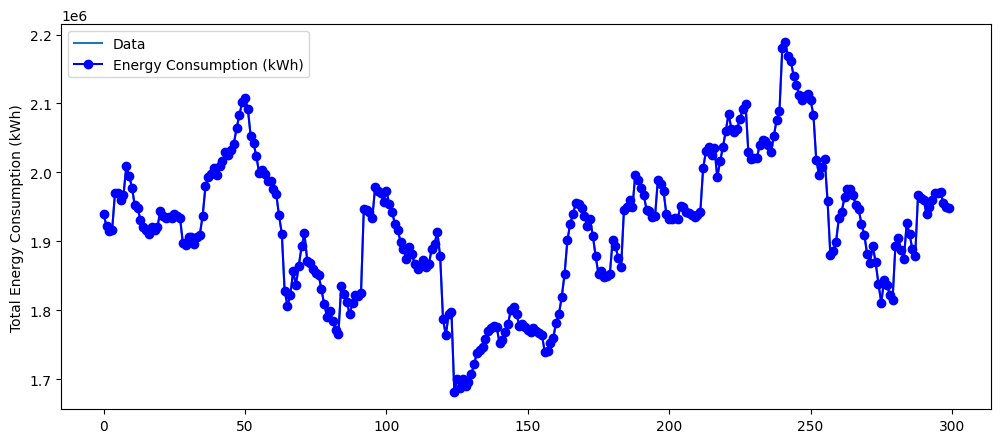

In [5]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].dropna().values 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(energy_consumption_data, label='Data')
plt.plot(energy_consumption_data, label="Energy Consumption (kWh)", color='blue', marker='o')
plt.ylabel("Total Energy Consumption (kWh)")
plt.legend()
plt.show()

#Ecrire l'unité (15 minutes) entre crochet []

Now that we have the data correct set up, let's create two tables: weights, prev_values and the bias

In [6]:
y = 100
bias = 0

energy_consumption_data = df['Total Energy Consumption (kWh)'].dropna().values
f_y = df['Total Energy Consumption (kWh)'][y]
print(f_y)


1973067.723669


We have multiple values to affix here, we need to find the weights to approximate our current consumed energy at time t (f(y)). We can use Linear regression to try to find the weights and the bias?

2nd test

prend la data et l'ordre ,   retourne (X, y) le vecteur des résultats

My lags are backwards, reversing the training window so that column 1 really is the 1-step-back value

je prenais le dernier element dans mon for loop et je l'append au début de la liste

In [7]:
import numpy as np
#X c'est lags
def create_dataset(data, p):
    X, y = [], []
    for i in range(len(data) - p):
        window = data[i : i + p]
        X.append(window[::-1])
        y.append(data[i+p])
    return np.array(X), np.array(y)


Performs gradient descent to find best coefficients.

y = X . B

avec l'erreur: e = y' -y


et le gradient est la dérivée par rapport à B pour MSE

donnée par 2/m * X(transposée) * e

In [8]:
def gradient_descent(X_augmented, y, coefficients, learning_rate, num_iter):
    m = len(y)
    cost_history = []
    
    
    for _ in range(num_iter):
        # Predictions
        predictions = X_augmented.dot(coefficients)
        error = predictions - y
        gradient = (X_augmented.T.dot(error)) * (2 / m)
        coefficients -= learning_rate * gradient
        # Compute cost
        cost = np.mean(error**2)
        cost_history.append(cost)
    
    return coefficients, cost_history


p :  valeurs passées (décalages) on va utiliser pour prédire la valeur actuelle.

learning_rate : C'est la taille du pas utilisée dans la descente de gradient. Cela détermine de combien on ajuste les coefficients à chaque itération.
num_iter : C'est le nombre d'itérations (ou étapes) pendant lesquelles la descente de gradient va tourner. Plus il y a d'itérations, plus les coefficients seront affinés.

AR_Gradient_descent, après avoir obtenu les coeffs, va prédire et imprimer la prochaine valeur y_t

La fonction retourne un tableau de coefficients. La première valeur est l'intercept, et les valeurs suivantes sont les coefficients AR (les weights).

Elle retourne aussi le cost_history

In [9]:

def ar_gradient_descent(data, p, learning_rate=0.001, num_iter=1000):
    X, y = create_dataset(data, p)
    m = X.shape[0]  
    
    # Add a column of ones to X pour le point d'interception (du début)
    X_augmented = np.hstack([np.ones((m, 1)), X])
    cost_history = []
    coefficients = np.zeros(p + 1)

    coefficients,cost_history = gradient_descent(X_augmented, y, coefficients, learning_rate, num_iter)
            
    last_p_observations = energy_consumption_data[-p:] 
    next_prediction = coefficients[0] + np.dot(last_p_observations, coefficients[1:])
    print(f"Predicted next value: {next_prediction}")
    return coefficients, cost_history

In [10]:
    # Normalize data
data_mean = np.mean(energy_consumption_data)
data_std = np.std(energy_consumption_data)
data_normalized = (energy_consumption_data - data_mean) / data_std

In [11]:
p = 7
cost_history=[]
coefficients, cost_history = ar_gradient_descent(data_normalized, p, learning_rate=0.01, num_iter=1000)
last_p_observations = energy_consumption_data[-p:] 
next_prediction = coefficients[0] + np.dot(last_p_observations, coefficients[1:])

Predicted next value: 1867837.5517070342


Plotting the coefficient

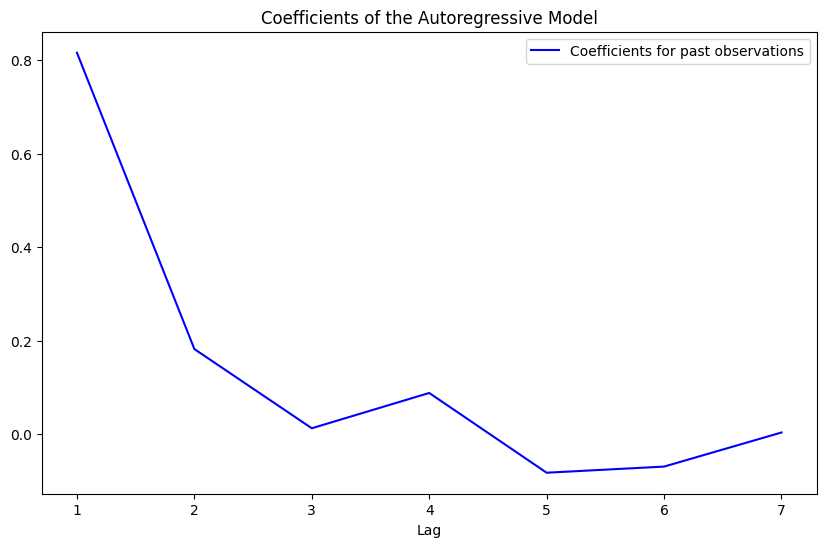

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, p + 1), coefficients[1:], label='Coefficients for past observations', color='blue')
plt.xlabel('Lag')
plt.title('Coefficients of the Autoregressive Model')
plt.legend()
plt.show()

Plotting Predictions

In [13]:
y_predictions = np.zeros_like(data_normalized) 
for i in range(p, len(data_normalized)):
    y_predictions[i] = coefficients[0] + np.dot(data_normalized[i-p:i], coefficients[1:])

print(y_predictions[-100:])


[ 0.18629831  0.15825922  0.28287027  0.6751075   0.59240153  0.44652438
  0.15282665  0.07979988  0.10415207  0.12661899  0.14682123  0.29751602
  0.26673432  0.20509573  0.13871997  0.04406672  0.06087536  0.12817276
  0.28188483  0.85136329  1.0881137   1.04558948  0.95275045  0.94531096
  0.66519699  0.93373629  1.12941614  1.33972851  1.4864341   1.29088282
  1.31665842  1.45435731  1.54222728  1.65526426  1.57524214  0.97422607
  0.90632213  0.93205949  0.97951429  1.13285184  1.14757304  1.11224537
  1.0022213   0.89349311  1.21391604  1.46659469  1.73951699  2.51212259
  2.54447437  2.36401893  2.25691973  2.04687205  1.91560472  1.81242874
  1.81682294  1.91980747  1.87097702  1.71623111  1.46885591  1.0167508
  0.87020139  0.89918595  0.83959643  0.18657071 -0.42761228 -0.37199399
 -0.19172431  0.12178462  0.2544992   0.45131932  0.56038081  0.56173577
  0.46958102  0.36463089  0.23965458  0.02267548 -0.09698974 -0.3169669
 -0.40280817 -0.30109758 -0.51163379 -0.79161031 -1.0

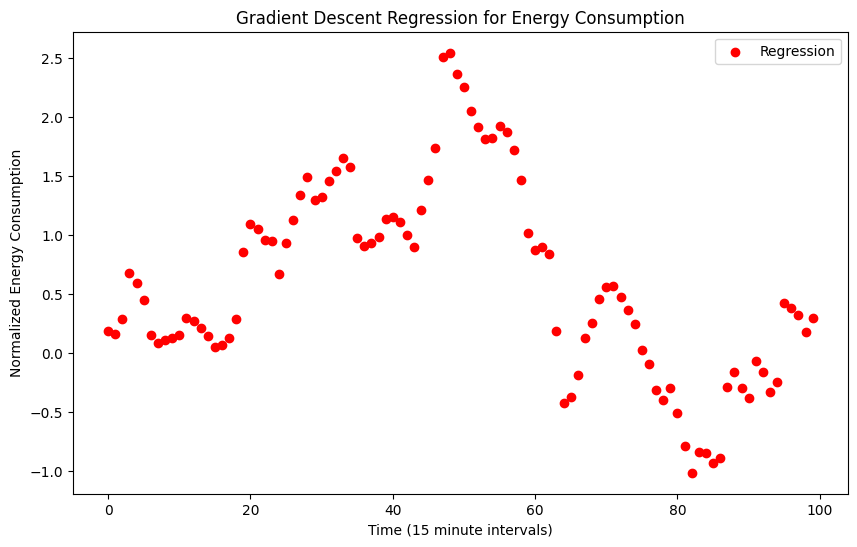

In [14]:
plt.figure(figsize=(10, 6))
X = np.arange(len(y_predictions[-100:]))  # X values for plotting
plt.scatter(X, y_predictions[-100:], color='red', label='Regression')
plt.xlabel('Time (15 minute intervals)')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()

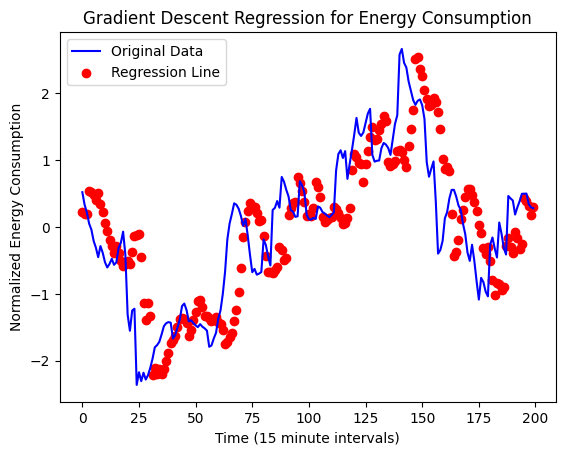

In [15]:
# Plotting
X = np.arange(len(data_normalized[0:200]))  # X values for plotting

# Plot original data and regression line
plt.plot(X, data_normalized[100:300], color='blue', label='Original Data')
plt.scatter(X, y_predictions[100:300], color='red', label='Regression Line')
plt.xlabel('Time (15 minute intervals)')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()


Tester avec petit lag, grand lag, petit learning rate, grand learning rate, petit iteration, grand iteration

petit lag: 7

In [16]:
    # Normalize data
data_mean = np.mean(energy_consumption_data)
data_std = np.std(energy_consumption_data)
data_normalized = (energy_consumption_data - data_mean) / data_std


In [17]:
p = 7
cost_history=[]
coefficients, cost_history = ar_gradient_descent(data_normalized, p, learning_rate=0.01, num_iter=1000)
last_p_observations = energy_consumption_data[-p:] 
next_prediction = coefficients[0] + np.dot(last_p_observations, coefficients[1:])
print(f"Predicted next value: {next_prediction}")

Predicted next value: 1867837.5517070342
Predicted next value: 1867837.5517070342


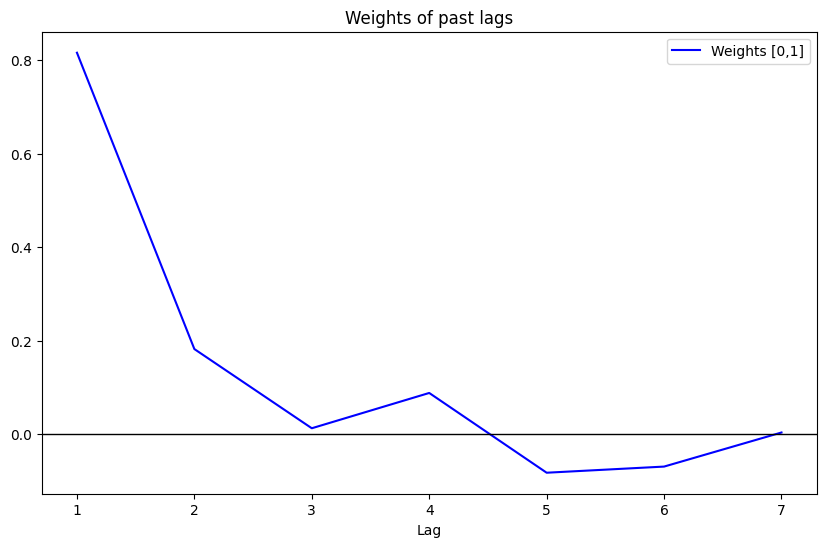

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, p + 1), coefficients[1:], label='Weights [0,1]', color='blue')
plt.axhline(0, color='black',linewidth=1) 
plt.xlabel('Lag')
plt.title('Weights of past lags')
plt.legend()
plt.show()

Plotting Predictions

In [19]:
y_predictions = np.zeros_like(data_normalized) 
for i in range(p, len(data_normalized)):
    y_predictions[i] = coefficients[0] + np.dot(data_normalized[i-p:i], coefficients[1:])

print(y_predictions[-100:])


[ 0.18629831  0.15825922  0.28287027  0.6751075   0.59240153  0.44652438
  0.15282665  0.07979988  0.10415207  0.12661899  0.14682123  0.29751602
  0.26673432  0.20509573  0.13871997  0.04406672  0.06087536  0.12817276
  0.28188483  0.85136329  1.0881137   1.04558948  0.95275045  0.94531096
  0.66519699  0.93373629  1.12941614  1.33972851  1.4864341   1.29088282
  1.31665842  1.45435731  1.54222728  1.65526426  1.57524214  0.97422607
  0.90632213  0.93205949  0.97951429  1.13285184  1.14757304  1.11224537
  1.0022213   0.89349311  1.21391604  1.46659469  1.73951699  2.51212259
  2.54447437  2.36401893  2.25691973  2.04687205  1.91560472  1.81242874
  1.81682294  1.91980747  1.87097702  1.71623111  1.46885591  1.0167508
  0.87020139  0.89918595  0.83959643  0.18657071 -0.42761228 -0.37199399
 -0.19172431  0.12178462  0.2544992   0.45131932  0.56038081  0.56173577
  0.46958102  0.36463089  0.23965458  0.02267548 -0.09698974 -0.3169669
 -0.40280817 -0.30109758 -0.51163379 -0.79161031 -1.0

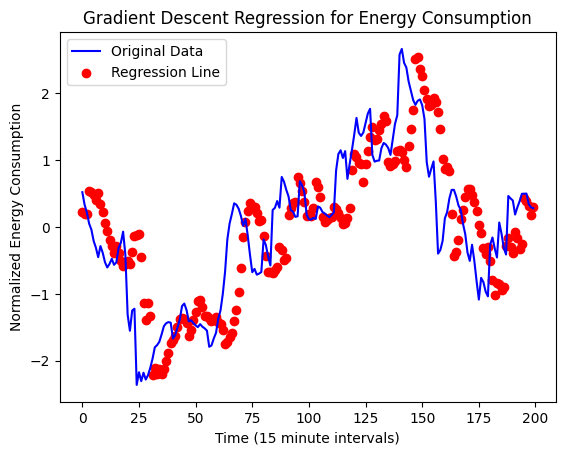

In [20]:
# Plotting
X = np.arange(len(data_normalized[0:200]))  # X values for plotting

# Plot original data and regression line
plt.plot(X, data_normalized[100:300], color='blue', label='Original Data')
plt.scatter(X, y_predictions[100:300], color='red', label='Regression Line')
plt.xlabel('Time (15 minute intervals)')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()


p = 50

In [21]:
p = 50
cost_history=[]
coefficients, cost_history = ar_gradient_descent(data_normalized, p, learning_rate=0.01, num_iter=1000)
last_p_observations = energy_consumption_data[-p:] 
next_prediction = coefficients[0] + np.dot(last_p_observations, coefficients[1:])
print(f"Predicted next value: {next_prediction}")

Predicted next value: 2009113.530279994
Predicted next value: 2009113.530279994


Plotting the coefficient

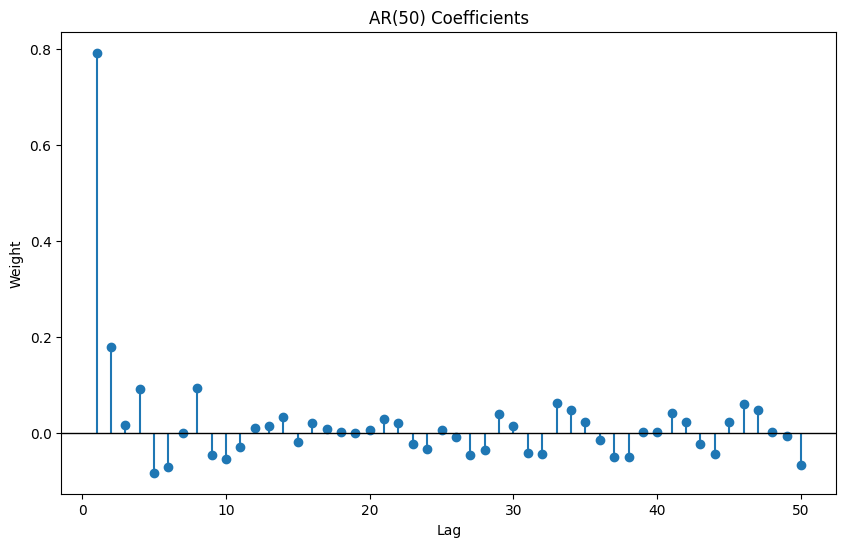

In [22]:
lags = np.arange(1, p+1)       
weights = coefficients[1:]       
plt.figure(figsize=(10,6))
plt.stem(lags, weights, basefmt=" ")
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Lag')
plt.ylabel('Weight')
plt.title(f'AR({p}) Coefficients')
plt.show()

In [23]:
y_predictions = np.zeros_like(data_normalized)

for i in range(p, len(data_normalized)):
    y_predictions[i] = (
        coefficients[0]
        + np.dot(data_normalized[i-p : i], coefficients[1:])
    )


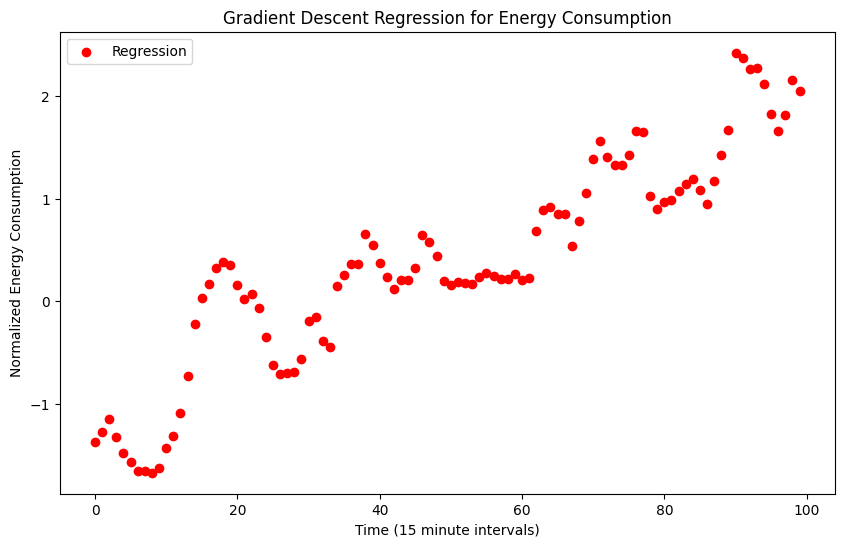

In [24]:
plt.figure(figsize=(10, 6))
X = np.arange(len(y_predictions[-100:]))  # X values for plotting
plt.scatter(X, y_predictions[-100:], color='red', label='Regression')
plt.xlabel('Time (15 minute intervals)')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()

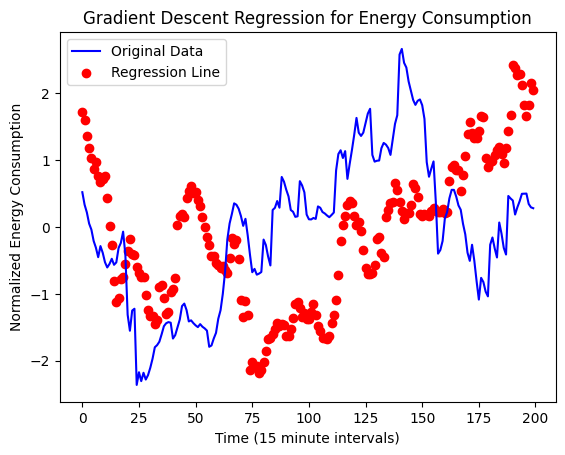

In [25]:
# Plotting
X = np.arange(len(data_normalized[0:200]))  # X values for plotting

# Plot original data and regression line
plt.plot(X, data_normalized[100:300], color='blue', label='Original Data')
plt.scatter(X, y_predictions[100:300], color='red', label='Regression Line')
plt.xlabel('Time (15 minute intervals)')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()


p = 7, learning rate = 0.001, iterations sans changement

In [26]:
p = 7
cost_history=[]
coefficients, cost_history = ar_gradient_descent(data_normalized, p, learning_rate=0.001, num_iter=1000)
last_p_observations = energy_consumption_data[-p:] 
next_prediction = coefficients[0] + np.dot(last_p_observations, coefficients[1:])
print(f"Predicted next value: {next_prediction}")

Predicted next value: 1828778.0298252087
Predicted next value: 1828778.0298252087


Plotting the coefficient

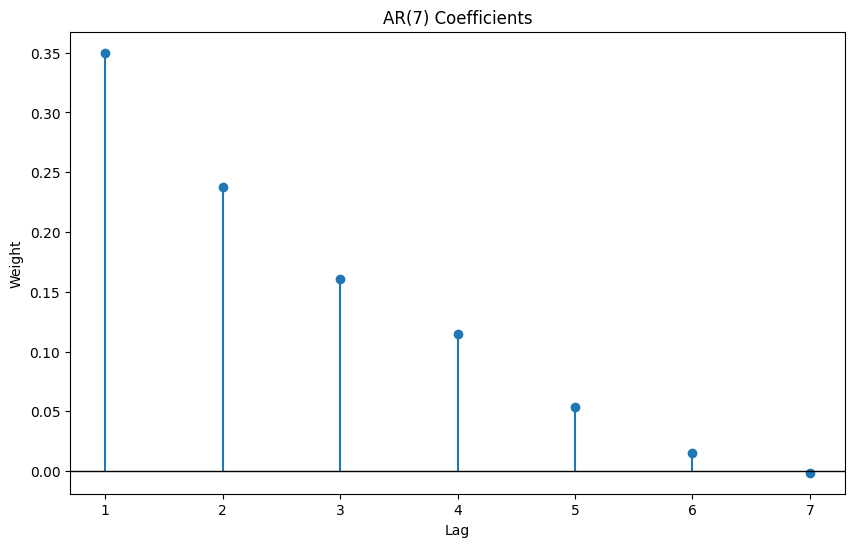

In [27]:
lags = np.arange(1, p+1)       
weights = coefficients[1:]       
plt.figure(figsize=(10,6))
plt.stem(lags, weights, basefmt=" ")
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Lag')
plt.ylabel('Weight')
plt.title(f'AR({p}) Coefficients')
plt.show()

In [28]:
y_predictions = np.zeros_like(data_normalized) 
for i in range(p, len(data_normalized)):
    y_predictions[i] = coefficients[0] + np.dot(data_normalized[i-p:i], coefficients[1:])

print(y_predictions[-100:])


[ 0.25851911  0.30051682  0.38733755  0.49729159  0.38924502  0.26334381
  0.13467612  0.12117887  0.14272287  0.17099271  0.19833828  0.2442731
  0.21431191  0.1805504   0.17654615  0.20659132  0.29788797  0.44861151
  0.65280676  0.92578422  0.99894276  0.97494165  0.9324779   0.94600834
  0.92416662  1.10504403  1.24453624  1.34696327  1.38955735  1.3344802
  1.36205367  1.40565809  1.41617828  1.36221763  1.21159679  0.96021619
  0.95392171  0.9959775   1.04623746  1.11723721  1.13435105  1.13677168
  1.17879426  1.3000152   1.56261092  1.81768961  2.06145079  2.34414886
  2.279626    2.13241136  2.01715379  1.88441259  1.79809564  1.73806438
  1.6996602   1.65039105  1.5198235   1.32096227  1.07219008  0.78234756
  0.64238694  0.52908285  0.3179999  -0.03361561 -0.22408421 -0.09504659
  0.07818171  0.26511038  0.35986109  0.44256998  0.44905879  0.38347118
  0.27054901  0.14006349  0.00812297 -0.15079318 -0.28063783 -0.4158161
 -0.48447281 -0.52102725 -0.68938295 -0.82605189 -0.86

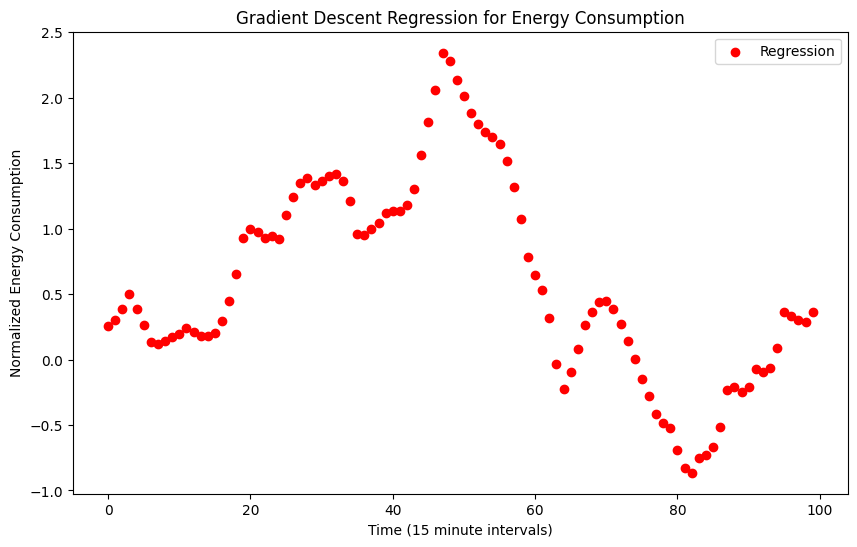

In [29]:
plt.figure(figsize=(10, 6))
X = np.arange(len(y_predictions[-100:]))  # X values for plotting
plt.scatter(X, y_predictions[-100:], color='red', label='Regression')
plt.xlabel('Time (15 minute intervals)')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()

**Define full start and end indices for plotting**



In [38]:
start_index = 100
end_index = 300

In [39]:
X = np.arange(start_index + p, end_index)
true_values_to_plot = data_normalized[start_index + p:end_index]

In [ ]:
# Plotting

# Plot original data and regression line
plt.plot(X, data_normalized[100:300], color='blue', label='Original Data')
plt.scatter(X, y_predictions[100:300], color='red', label='Regression Line')
plt.xlabel('Time (15 minute intervals)')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()


NameError: name 'start_index' is not defined

p = 7, learning rate 0.01, 100 iterations

In [31]:
p = 7
cost_history=[]
coefficients, cost_history = ar_gradient_descent(data_normalized, p, learning_rate=0.01, num_iter=100)
last_p_observations = energy_consumption_data[-p:] 
next_prediction = coefficients[0] + np.dot(last_p_observations, coefficients[1:])
print(f"Predicted next value: {next_prediction}")

Predicted next value: 1828794.6251567123
Predicted next value: 1828794.6251567123


Plotting the coefficient

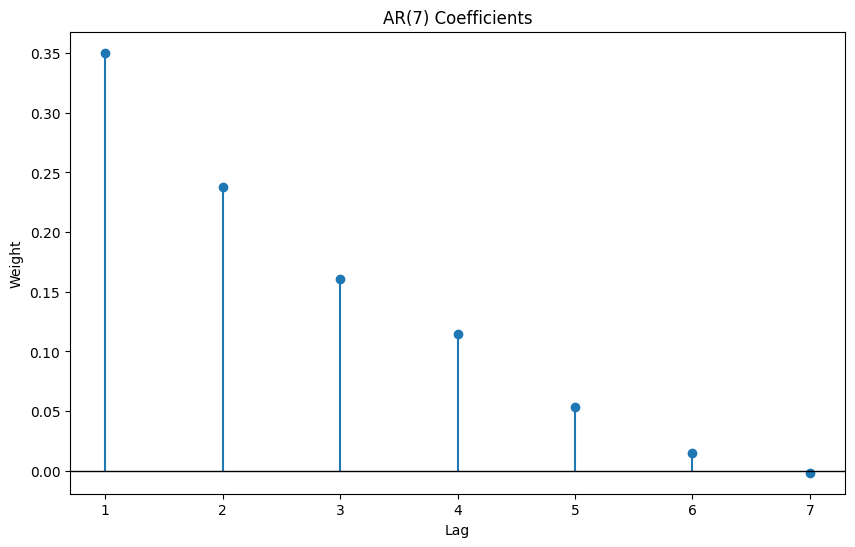

In [32]:
lags = np.arange(1, p+1)       
weights = coefficients[1:]       
plt.figure(figsize=(10,6))
plt.stem(lags, weights, basefmt=" ")
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Lag')
plt.ylabel('Weight')
plt.title(f'AR({p}) Coefficients')
plt.show()

In [33]:
y_predictions = np.zeros_like(data_normalized) 
for i in range(p, len(data_normalized)):
    y_predictions[i] = coefficients[0] + np.dot(data_normalized[i-p:i], coefficients[1:])

print(y_predictions[-100:])


[ 0.25834826  0.30052443  0.38756975  0.49771594  0.3895707   0.26345684
  0.13459037  0.12106487  0.14263669  0.17096375  0.19837785  0.24437489
  0.21436677  0.18033197  0.17603562  0.20587271  0.29714323  0.44795562
  0.65251537  0.92584884  0.99903522  0.9748714   0.93214396  0.94559037
  0.92370736  1.10479228  1.24441732  1.34688172  1.38941618  1.33443828
  1.36224028  1.40605892  1.41671519  1.36267664  1.21179076  0.96006118
  0.9537383   0.99587771  1.04615913  1.11712336  1.1341082   1.13609051
  1.17778064  1.29895622  1.56177763  1.81723233  2.06144452  2.34462874
  2.28016291  2.13284178  2.01746804  1.88460086  1.79826997  1.73846991
  1.70035143  1.65123111  1.52059831  1.32172402  1.07307619  0.78322194
  0.64330143  0.52985028  0.31838195 -0.03385199 -0.22472677 -0.09565475
  0.07774791  0.2649395   0.35988126  0.44282559  0.44948054  0.38402405
  0.27116688  0.14057981  0.00857471 -0.15036918 -0.28015726 -0.41543137
 -0.48411655 -0.52066163 -0.6891707  -0.82622642 -0

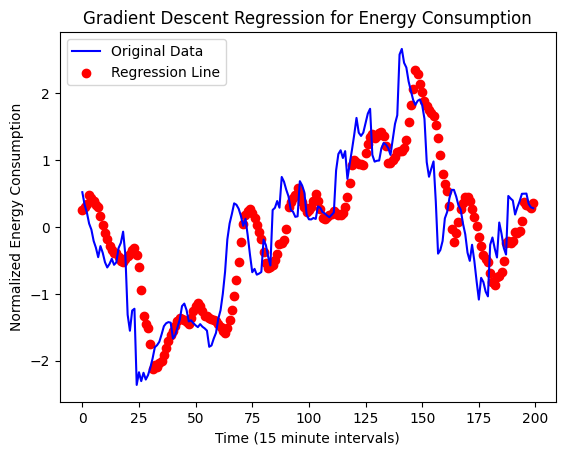

In [34]:
# Plotting
X = np.arange(len(data_normalized[0:200]))

# Plot original data and regression line
plt.plot(X, data_normalized[100:300], color='blue', label='Original Data')
plt.scatter(X, y_predictions[100:300], color='red', label='Regression Line')
plt.xlabel('Time (15 minute intervals)')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()
